# Отток клиентов

"Бета-Банк" столкнулся с проблемой оттока клиентов. По мнению банковских маркетологов, сохранять текущих клиентов дешевле, чем привлекать новых. 

Нам поставлена задача спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Для проведения анализа были предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

**Цель** - построить модель с предельно большим значением F1-меры (не менее 0.59).

Для решения поставленной задачи необходимо выделить следующие этапы:

1. Подготовка данных.
2. Исследование баланса классов.
3. Изучение модели без учета дисбаланса.
4. Создание балансированной модели.
5. Проведение тестирования.
6. Исследование метрики AUC-ROC.

<h1>Содержание<span class="tocSkip"></span></h1>
<div<span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Подготовка данных

In [320]:
# загрузим все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None

In [321]:
# загрузим таблицу с данными 
df = pd.read_csv('/datasets/Churn.csv')

In [322]:
# посмотрим на 1-ые пять строчек таблицы
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [323]:
# удалим ненужные столбцы RowNumber, Customerld и Surname, которые не понадобятся в дальнейшем анализе
df = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

In [324]:
# посмотрим на общую информацию о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Мы видим, что в столбце Tenure содержатся пропуски. Заменим их на медианное значение. Также следует поменять формат данных на int.

In [325]:
# замена пропусков на медианное значение
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median()).astype('int16')

In [326]:
# проверим данные на наличие дубликатов
df.duplicated().sum()

0

Дубликатов не обнаружено.

In [327]:
# преобразуем категориальные признаки техникой OHE
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


**Вывод**

Таблица с анализируемыми данными содержит 14 признаков и 10000 объектов. Согласно приложенной документации:

- RowNumber — индекс строки в данных;
- CustomerId — уникальный идентификатор клиента;
- Surname — фамилия;
- CreditScore — кредитный рейтинг;
- Geography — страна проживания;
- Gender — пол;
- Age — возраст;
- Tenure — сколько лет человек является клиентом банка;
- Balance — баланс на счёте;
- NumOfProducts — количество продуктов банка, используемых клиентом;
- HasCrCard — наличие кредитной карты;
- IsActiveMember — активность клиента;
- EstimatedSalary — предполагаемая зарплата;
- Exited — факт ухода клиента.

В процессе предобработки данных пропуски в столбце Tenure были заменены на медианное значение. Также были удалены столбцы RowNumber, CustomerId и Surname, так они не понадобятся нам для дальнейшего анализа. В качестве целевого признака будет выступать Exited.

## Исследование задачи

In [328]:
# выделим в нашей выборке признаки и целевой признак
features = df_ohe.drop(['Exited'], axis=1)
target = df_ohe['Exited']

In [329]:
# разделим выборку на обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4,
                                                                             random_state=12345)

In [330]:
# выделим 50% валидационной выборки на тестовую
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,
                                                                              random_state=12345)

In [331]:
features_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7041,438,38,2,0.00,2,1,0,136859.55,0,0,1
5709,644,39,9,0.00,1,1,0,3740.93,0,0,0
7117,564,31,5,121461.87,1,1,1,20432.09,0,1,1
7775,628,40,10,0.00,2,1,0,103832.58,0,1,1
8735,728,30,10,114835.43,1,0,1,37662.49,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9335,737,50,4,127552.85,2,1,0,4225.11,1,0,1
7999,826,26,5,142662.68,1,0,0,60285.30,0,0,1
6139,652,37,4,0.00,2,1,0,143393.24,0,0,0
9473,608,45,4,0.00,2,0,0,36697.48,0,1,1


In [332]:
# проверим целевой признак на сбалансированность классов
class_frequency = df['Exited'].value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

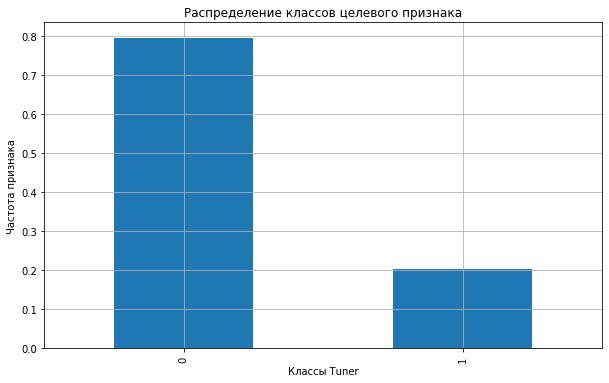

In [333]:
# построим диаграмму частот классов в целевом признаке
class_frequency.plot(kind='bar', title='Распределение классов целевого признака', grid=True, figsize=(10, 6))
plt.xlabel('Классы Tuner')
plt.ylabel('Частота признака')
plt.show()

Видим, что соотношение классов далеко от идеального 1 к 1. В указанной выборке представены данные о клиентах, которые покинули банк, в количестве 20%. При этом осталось 80% клиентов.

Изучим модели без учета дисбаланса. Но перед этим проведем стандартизацию численных признаков.

In [334]:
# соберем всем численные признаки в одном списке
numeric = list(df_ohe.drop(['Exited'], axis=1).columns)

In [335]:
# стандартизируем численные признаки
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

Построим модели без учета дисбаланса.

**Модель логистической регрессии**

In [336]:
# построим модель логистической регрессии и оценим ее метрикой F1
model=LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions_regression = model.predict(features_valid)
print('F1-мера:', f1_score(target_valid, predictions_regression))

F1-мера: 0.33108108108108103


**Модель решающего дерева**

In [337]:
# построим модель решающего дерева с перебором оптимальной глубины
best_tree_model=None
best_depth=0
best_f1=0

for depth in range(1, 20, 1):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_tree = model.predict(features_valid)
    print('Глубина дерева:', depth, '/ F1-мера:', f1_score(target_valid, predictions_tree))
    if f1_score(target_valid, predictions_tree) > best_f1:
        best_f1=f1_score(target_valid, predictions_tree)
        best_tree_model=model
        best_depth=depth
print('-------------------------------------------------------')        
print('F1 лучшей модели:', best_f1)
print('Лучшая глубина дерева:', best_depth)

Глубина дерева: 1 / F1-мера: 0.0
Глубина дерева: 2 / F1-мера: 0.5217391304347825
Глубина дерева: 3 / F1-мера: 0.4234875444839857
Глубина дерева: 4 / F1-мера: 0.5528700906344411


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Глубина дерева: 5 / F1-мера: 0.5406249999999999
Глубина дерева: 6 / F1-мера: 0.5696969696969697
Глубина дерева: 7 / F1-мера: 0.5320813771517998
Глубина дерева: 8 / F1-мера: 0.5454545454545454
Глубина дерева: 9 / F1-мера: 0.5633802816901409
Глубина дерева: 10 / F1-мера: 0.5385694249649369
Глубина дерева: 11 / F1-мера: 0.5059920106524634
Глубина дерева: 12 / F1-мера: 0.521072796934866
Глубина дерева: 13 / F1-мера: 0.5038961038961038
Глубина дерева: 14 / F1-мера: 0.48675914249684743
Глубина дерева: 15 / F1-мера: 0.4975124378109453
Глубина дерева: 16 / F1-мера: 0.4987654320987654
Глубина дерева: 17 / F1-мера: 0.4767726161369193
Глубина дерева: 18 / F1-мера: 0.48522167487684725
Глубина дерева: 19 / F1-мера: 0.49521531100478466
-------------------------------------------------------
F1 лучшей модели: 0.5696969696969697
Лучшая глубина дерева: 6


В модели решающего дерева максимальное значение F1 достигается при глубине дерева 6.

**Модель случайного леса**

In [338]:
# построим модель случайного леса с перебором оптимальной глубины
best_forest_model=None
best_depth=0
best_f1=0

for depth in range(1, 20, 1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=100)
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Глубина дерева:', depth, '/ F1-мера:', f1_score(target_valid, predictions_forest))
    if f1_score(target_valid, predictions_forest) > best_f1:
        best_forest_model=model
        best_f1=f1_score(target_valid, predictions_forest)
        best_depth=depth
print('-------------------------------------------------------')
print('F1 лучшей модели:', best_f1)
print('Лучшая глубина дерева:', best_depth)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Глубина дерева: 1 / F1-мера: 0.0
Глубина дерева: 2 / F1-мера: 0.1294642857142857
Глубина дерева: 3 / F1-мера: 0.23382045929018794
Глубина дерева: 4 / F1-мера: 0.3805970149253731
Глубина дерева: 5 / F1-мера: 0.4660869565217391
Глубина дерева: 6 / F1-мера: 0.5266666666666666
Глубина дерева: 7 / F1-мера: 0.5596184419713831
Глубина дерева: 8 / F1-мера: 0.5641025641025641
Глубина дерева: 9 / F1-мера: 0.5606299212598426
Глубина дерева: 10 / F1-мера: 0.5692068429237946
Глубина дерева: 11 / F1-мера: 0.5701078582434514
Глубина дерева: 12 / F1-мера: 0.5878787878787878
Глубина дерева: 13 / F1-мера: 0.5731707317073171
Глубина дерева: 14 / F1-мера: 0.5787106446776611
Глубина дерева: 15 / F1-мера: 0.5838323353293413
Глубина дерева: 16 / F1-мера: 0.5791044776119403
Глубина дерева: 17 / F1-мера: 0.5799701046337816
Глубина дерева: 18 / F1-мера: 0.5630769230769231
Глубина дерева: 19 / F1-мера: 0.5864661654135339
-------------------------------------------------------
F1 лучшей модели: 0.5878787878787878

В модели случайного леса максимальное значение F1 достигается при глубине дерева 12.

In [339]:
# построим модель случайного леса с перебором количества деревьев
best_forest_model=None
best_estimators=0
best_f1=0

for estimators in range(1, 100, 4):
    model = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=estimators)
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Количество деревьев:', estimators, '/ F1-мера:', f1_score(target_valid, predictions_forest))
    if f1_score(target_valid, predictions_forest) > best_f1:
        best_forest_model=model
        best_f1=f1_score(target_valid, predictions_forest)
        best_estimators=estimators
print('-------------------------------------------------------')
print('F1 лучшей модели:', best_f1)
print('Лучшее количество деревьев:', best_estimators)

Количество деревьев: 1 / F1-мера: 0.5158150851581509
Количество деревьев: 5 / F1-мера: 0.5624103299856528
Количество деревьев: 9 / F1-мера: 0.5811209439528023
Количество деревьев: 13 / F1-мера: 0.5650224215246636
Количество деревьев: 17 / F1-мера: 0.5748502994011976
Количество деревьев: 21 / F1-мера: 0.5662650602409639
Количество деревьев: 25 / F1-мера: 0.572289156626506
Количество деревьев: 29 / F1-мера: 0.5727272727272728
Количество деревьев: 33 / F1-мера: 0.5774436090225564
Количество деревьев: 37 / F1-мера: 0.5791855203619909
Количество деревьев: 41 / F1-мера: 0.5757575757575758
Количество деревьев: 45 / F1-мера: 0.5801526717557252
Количество деревьев: 49 / F1-мера: 0.5758039816232772
Количество деревьев: 53 / F1-мера: 0.5844748858447488
Количество деревьев: 57 / F1-мера: 0.578386605783866
Количество деревьев: 61 / F1-мера: 0.5800604229607251
Количество деревьев: 65 / F1-мера: 0.5792682926829268
Количество деревьев: 69 / F1-мера: 0.5887708649468891
Количество деревьев: 73 / F1-мера

В модели случайного леса максимальное значение F1 достигается при количестве деревьев 85.

**Вывод**

В процессе исследования данных было обнаружен дисбаланс классов целевого признака, что не позволяет эффективно обучить модель. Согласно изученной информации, 20% занимают данные о клиентах, которые покинули банк, и 80% - которые остались лояльны к банку.

Также были построены модели и посчитана F1-мера путем перебора различных гиперпараметров без учета дисбаланса. Самой эффективной моделью оказалась модель случайного леса.

## Борьба с дисбалансом

Для решения проблемы с дисбалансом применим три метода:
1. Взвешивание классов.
2. Увеличение выборки.
3. Уменьшение выборки.

**Взвешивание классов**

In [340]:
# создадим функцию для расчета F1-меры после применения метода взвешивания классов
def calc_f1(model_ml, features, target):
    model=model_ml
    model.fit(features, target)
    predicted_valid = model.predict(features_valid)
    print('F1-мера:', f1_score(target_valid, predicted_valid))

In [341]:
# выделим три модели
model_1 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_2 = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=6)
model_3 = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=12, n_estimators=85)

In [342]:
# рассчитаем F1 для каждой модели
calc_f1(model_1, features_train, target_train)
calc_f1(model_2, features_train, target_train)
calc_f1(model_3, features_train, target_train)

F1-мера: 0.4888507718696398
F1-мера: 0.5581835383159887
F1-мера: 0.600265604249668


Метод взвешивания классов позволил улучшить качество всех трех моделей. Особенно заметное усовершенствование произошло у модели логистической регрессии.

**Увеличение выборки**

In [343]:
# создадим функцию upsample для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [344]:
# создадим переменные features_upsampled и target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)  
# в данной ситуации repeat равно 4, так как именно в данное количество раз количество клиентов, которые остались,
# превышает число клиентов, которые ушли.

In [345]:
# выделим три модели и применим к ним функцию calc_f1 с учетом увеличенной выборки
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_2 = DecisionTreeClassifier(random_state=12345, max_depth=6)
model_3 = RandomForestClassifier(random_state=12345, max_depth=12, n_estimators=85)

calc_f1(model_1, features_upsampled, target_upsampled)
calc_f1(model_2, features_upsampled, target_upsampled)
calc_f1(model_3, features_upsampled, target_upsampled)

F1-мера: 0.4888507718696398
F1-мера: 0.5581835383159887
F1-мера: 0.5990675990675991


Метод увеличения выборки позволил улучшить качество всех трех моделей. Особенно заметное усовершенствование произошло у модели логистической регрессии.

**Уменьшение выборки**

In [346]:
# создадим функцию upsample для уменьшения выборки
def downsample(features, target, fraction):
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [347]:
# создадим переменные features_downsampled и target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)  

In [348]:
# применим к моделям функцию calc_f1 с учетом уменьшенной выборки
calc_f1(model_1, features_downsampled, target_downsampled)
calc_f1(model_2, features_downsampled, target_downsampled)
calc_f1(model_3, features_downsampled, target_downsampled)

F1-мера: 0.4849527085124678
F1-мера: 0.5749525616698292
F1-мера: 0.5909943714821764


Метод уменьшения выборки позволил улучшить качество всех трех моделей. Особенно заметное усовершенствование произошло у модели логистической регрессии.

Модель случайного леса продемонстрировала самый высокий показатель F1-меры. При этом при взвешивании классов данный показатель достиг самого высокого значения. Найдем оптимальные гиперпараметры для модели случайного леса с учетом дисбаланса.

In [349]:
# построим модель случайного леса с перебором максимальной глубины с шагом 5
for depth in range(1, 30, 5):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=100, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Глубина дерева:', depth, '/ F1-мера:', f1_score(target_valid, predictions_forest))

Глубина дерева: 1 / F1-мера: 0.5446096654275093
Глубина дерева: 6 / F1-мера: 0.6175869120654396
Глубина дерева: 11 / F1-мера: 0.6089171974522293
Глубина дерева: 16 / F1-мера: 0.5641791044776119
Глубина дерева: 21 / F1-мера: 0.5622119815668203
Глубина дерева: 26 / F1-мера: 0.5630769230769231


Максимальное значение F1-меры необходимо искать в диапозоне максимальной глубины между 6 и 11.

In [350]:
# построим модель случайного леса с перебором максимальной глубины в диапозоне от 6 до 11.
best_forest_model=None
best_depth=0
best_f1=0

for depth in range(6, 12, 1):
    model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=100, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Глубина дерева:', depth, '/ F1-мера:', f1_score(target_valid, predictions_forest))
    if f1_score(target_valid, predictions_forest) > best_f1:
        best_forest_model=model
        best_f1=f1_score(target_valid, predictions_forest)
        best_depth=depth
print('-------------------------------------------------------')
print('F1 лучшей модели:', best_f1)
print('Лучшая глубина дерева:', best_depth)

Глубина дерева: 6 / F1-мера: 0.6175869120654396
Глубина дерева: 7 / F1-мера: 0.630457933972311
Глубина дерева: 8 / F1-мера: 0.6267995570321152
Глубина дерева: 9 / F1-мера: 0.6313364055299538
Глубина дерева: 10 / F1-мера: 0.618531889290012
Глубина дерева: 11 / F1-мера: 0.6089171974522293
-------------------------------------------------------
F1 лучшей модели: 0.6313364055299538
Лучшая глубина дерева: 9


Самая оптимальная глубина дерева будет равна 9.

In [351]:
# построим модель случайного леса с перебором количества деревьев с шагом 50
for estimators in range(1, 500, 50):
    model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=estimators, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Количество деревьев:', estimators, '/ F1-мера:', f1_score(target_valid, predictions_forest))

Количество деревьев: 1 / F1-мера: 0.5307621671258036
Количество деревьев: 51 / F1-мера: 0.6313364055299538
Количество деревьев: 101 / F1-мера: 0.6289017341040462
Количество деревьев: 151 / F1-мера: 0.6356228172293364
Количество деревьев: 201 / F1-мера: 0.6349942062572421
Количество деревьев: 251 / F1-мера: 0.6351039260969977
Количество деревьев: 301 / F1-мера: 0.630359212050985
Количество деревьев: 351 / F1-мера: 0.629500580720093
Количество деревьев: 401 / F1-мера: 0.6271777003484321
Количество деревьев: 451 / F1-мера: 0.629500580720093


Максимальное значение F1-меры необходимо искать в диапозоне количества деревьев между 151 и 201.

In [352]:
# построим модель случайного леса с перебором количества деревьев в диапозоне между 151 и 201
for estimators in range(151, 202, 10):
    model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=estimators, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Количество деревьев:', estimators, '/ F1-мера:', f1_score(target_valid, predictions_forest))

Количество деревьев: 151 / F1-мера: 0.6356228172293364
Количество деревьев: 161 / F1-мера: 0.6372093023255814
Количество деревьев: 171 / F1-мера: 0.6357308584686775
Количество деревьев: 181 / F1-мера: 0.6358381502890174
Количество деревьев: 191 / F1-мера: 0.6335260115606937
Количество деревьев: 201 / F1-мера: 0.6349942062572421


In [353]:
# построим модель случайного леса с перебором количества деревьев в диапозоне между 141 и 151
best_forest_model=None
best_estimators=0
best_f1=0

for estimators in range(141, 152, 1):
    model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=estimators, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions_forest = model.predict(features_valid)
    print('Количество деревьев:', estimators, '/ F1-мера:', f1_score(target_valid, predictions_forest))
    if f1_score(target_valid, predictions_forest) > best_f1:
        best_forest_model=model
        best_f1=f1_score(target_valid, predictions_forest)
        best_estimators=estimators
print('-------------------------------------------------------')
print('F1 лучшей модели:', best_f1)
print('Лучшее количество деревьев:', best_estimators)

Количество деревьев: 141 / F1-мера: 0.632438739789965
Количество деревьев: 142 / F1-мера: 0.6340326340326341
Количество деревьев: 143 / F1-мера: 0.6356228172293364
Количество деревьев: 144 / F1-мера: 0.6348837209302326
Количество деревьев: 145 / F1-мера: 0.6325581395348838
Количество деревьев: 146 / F1-мера: 0.6348837209302326
Количество деревьев: 147 / F1-мера: 0.6348837209302326
Количество деревьев: 148 / F1-мера: 0.6348837209302326
Количество деревьев: 149 / F1-мера: 0.6348837209302326
Количество деревьев: 150 / F1-мера: 0.6356228172293364
Количество деревьев: 151 / F1-мера: 0.6356228172293364
-------------------------------------------------------
F1 лучшей модели: 0.6356228172293364
Лучшее количество деревьев: 143


Самый лучший результат демонстрирует модель случайного леса, сбалансированная с помощью метода взвешивания классов, с глубиной дерева 9 и количеством деревьев 143.

**Вывод**

Борьба с несбалансированной классификацией с помощью методов взвешивания классов, увеличения и уменьшения выборки позволил повысить значение метрики F1 для каждой из трех моделей. Cамое большое увеличение показателя произошло у модели логистической регрессии, при этом данная модель по-прежнему демонстрирует самый низкий показатель значения F1.

## Тестирование модели

Проверим нашу модель на тестовой выборке.

In [354]:
# стандартизируем тестовые данные
features_test[numeric] = scaler.transform(features_test[numeric])

In [355]:
# тестирование модели
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=143, class_weight='balanced')
model.fit(features_train, target_train)
predictions_test=model.predict(features_test)
print('F1 тестовой выборки:', f1_score(target_test, predictions_test))
print('Точность тестовой выборки:', precision_score(target_test, predictions_test))
print('Полнота тестовой выборки:', recall_score(target_test, predictions_test))

F1 тестовой выборки: 0.6123853211009175
Точность тестовой выборки: 0.5946547884187082
Полнота тестовой выборки: 0.6312056737588653


На тестовой выборке модель показала результат, сравнимый с результатом на валидационной выборке, что говорит о высоком качестве модели.

**Исследование метрики AUC-ROC**

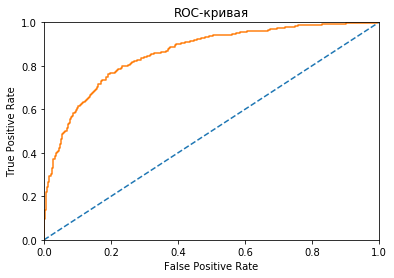

In [356]:
# построим ROC-кривую для случайного леса
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=143, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [357]:
# посчитаем для случайного леса значение AUC-ROC
print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))

AUC-ROC: 0.8579341629301829


Значение площади под кривой, равное 0.86, говорит о высокой способности модели различать положительные и отрицательные классы.

**Вывод**

Таким образом, нами была создана модель предсказания оттока клиентов из "Бета-банка". Модель случайного леса с количеством деревьев 143 и глубиной дерева 9 выдала самый высокий результат F1-меры на валидационной выборке - 0.64. Для создания эффективной модели также был использован метод взвешивания классов, так как в изначальном виде целевой признак имеет явный дисбаланс классов. На тестовой выборке модель показала результат, близкий результаты на валидационной выборке. Также большое значение AUC-ROC (0.86) говорит о том, что наша модель способна эффективно определять принадлежность клиента к тому или иному классу.